## Advanced Box Score Calculations
Author: Akshay Easwaran <akeaswaran@me.com>

---
Based on work by ESPN's Bill Connelly, Football Outsiders, and Football Study Hall

Data from CollegeFootballData.com

Useful Resources for Stat Definitions:
- Football Study Hall website: https://www.footballstudyhall.com/
- Football Study Hall book: https://www.amazon.com/Study-Hall-College-Football-Stories/dp/1484989961
- Football Outsiders: https://www.footballoutsiders.com/info/glossary
- Example Advanced Box Score: https://twitter.com/ESPN_BillC/status/1176572006969597954/photo/1

**How to use this Notebook**

1. Dump game, play by play, and drive data for an entire season from CollegeFootballData.com.
2. Change the file names in the next cell to match where your data files are located.
3. Change the away and home team names appropriately.
4. Hit Cell > Run All Cells.

In [460]:
# import pandas as pd

# base_drives = pd.read_json('data/drives/drive-data-national.json')
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed','start_period','end_period'], axis = 1, inplace=True) 
# base_drives = base_drives[
#     ~base_drives.drive_result.isin(['Uncategorized'])
# ]

# games = pd.read_json('data/games/game-data-national.json')

# selected_team = 'National'

In [461]:
# # Data Cleaning
# # Fix the bad yard line markers for away teams
# drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
# drives.rename(columns={'id_x':'drive_id'}, inplace=True)
# drives.drop(['id_y'], axis = 1, inplace=True)
# drives.dropna(inplace=True)
# drives.loc[
#     drives.offense == drives.away_team, ['start_yardline']
# ] = 100 - drives.start_yardline
# drives.loc[
#     drives.offense == drives.away_team, ['end_yardline']
# ] = 100 - drives.end_yardline

# print("Total Drives:", len(drives))
# # drives

In [462]:
# print(selected_team, "Drives:", len(drives))

# print(selected_team, "Avg Starting Field Position:", sum(drives.start_yardline) / len(drives))
# print(selected_team, "Mdn Starting Field Position:", drives.start_yardline.median())
# print("")

# drives['yards_per_play'] = drives.apply(lambda x: (x.yards / x.plays) if (x.plays > 0) else 0, axis=1)
# print(selected_team, "Avg Yards per Play:", drives.yards_per_play.mean())
# print(selected_team, "Mdn Yards per Play:", drives.yards_per_play.median())

# print("")
# print(selected_team, "Avg Plays per Drive:", drives.plays.mean())
# print(selected_team, "Mdn Plays per Drive:", drives.plays.median())

# print("")
# print(selected_team, "Avg Yards per Drive:", drives.yards.mean())
# print(selected_team, "Mdn Yards per Drive:", drives.yards.median())

In [463]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1,figsize=(12,8))
# ax.hist(drives.yards, bins=[-20,-10,0,10,20,30,40,50,60,70,80,90,100]);
# ax.set_ylabel("Frequency");
# ax.set_xlabel("Drive Yardage");

In [464]:
# fig, ax = plt.subplots(1, 1,figsize=(12,8))
# ax.scatter(drives.start_yardline, drives.yards_per_play);
# ax.set_ylabel("yards per play");
# ax.set_xlabel("Start Position");

In [465]:
# pbp_data = pd.read_json('data/pbp/pbp-data-national.json')
# # Eliminate garbage time plays
# # garbage_time_data = pbp_data[
# #     (pbp_data.down == 0)
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 38) & (pbp_data.period == 2))
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 28) & (pbp_data.period == 3))
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 22) & (pbp_data.period == 4))
# # ]

# print("Total Plays:", len(pbp_data))
# # print("Garbage Time Plays:", len(garbage_time_data))
# # pbp_data.drop(garbage_time_data.index, inplace=True)
# print("Non-Garbage Time Plays:", len(pbp_data))

# # Drop some unnecessary columns
# pbp_data.drop(['offense_conference','defense_conference','clock'], axis = 1, inplace=True) 
# # Ignore some types of plays cause they're special teams and weird
# ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
# pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types))]
# print("Total clean plays:", len(pbp_data))

In [466]:
# import numpy as np

# pbp_data.distance = pbp_data.distance.astype(float)

# bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

# def is_successful(down, distance, yards_gained, play_type):
#     if (play_type in bad_types):
#         return False 
#     if ((down == 1) & (yards_gained >= (0.5 * distance))):
#         return True
#     elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
#         return True
#     elif (((down == 3) | (down == 4)) & (yards_gained >= distance)):
#         return True
#     else:
#         return False
    
# pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
# pbp_data.play_successful.value_counts()

# def is_explosive(yards_gained):
#     if (yards_gained >= 15):
#         return True
#     else:
#         return False
    
# pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)

In [467]:
# pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown"]
# rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

# print("Offensive Success Rates")
# base_overall = len(pbp_data[(pbp_data.play_successful == True)]) / len(pbp_data)
# print("Overall:",base_overall)
# base_passing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
# print("Passing:",base_passing)
# base_rushing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
# print("Rushing:",base_rushing)
# print("")


# print("Offensive Explosiveness Rates")
# base_exp_overall = len(pbp_data[(pbp_data.play_explosive == True)]) / len(pbp_data)
# print("Overall:",base_exp_overall)
# base_exp_passing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
# print("Passing:",base_exp_passing)
# base_exp_rushing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
# print("Rushing:",base_exp_rushing)
# print("")

In [468]:
# # SR+
# selected_team = 'Georgia Tech'
# selected_team_data = pbp_data[
#     (pbp_data.offense == selected_team)
#     | (pbp_data.defense == selected_team)
# ]

# overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
# passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
# rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

# exp_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
# exp_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
# exp_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

# def_overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
# def_passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
# def_rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])

# exp_def_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
# exp_def_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
# exp_def_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])


# def plus_adj(base, comp):
#     diff = comp - base
#     pct = (diff / base) * 100
#     return 100 + pct

# print(selected_team,"SR+ Stats")
# print("")

# print("Offensive (higher + is better)")
# print("Overall Off SR:",overall)
# print("Overall Off SR+:",plus_adj(base_overall, overall))
# print("")
# print("Passing Off SR:",passing)
# print("Passing Off SR+:",plus_adj(base_passing, passing))
# print("")
# print("Rushing Off SR:",rushing)
# print("Rushing Off SR+:",plus_adj(base_rushing, rushing))

# print("")

# print("Overall Off ER:",exp_overall)
# print("Overall Off ER+:",plus_adj(base_exp_overall, exp_overall))
# print("")
# print("Passing Off ER:",exp_passing)
# print("Passing Off ER+:",plus_adj(base_exp_passing, exp_passing))
# print("")
# print("Rushing Off ER:",exp_rushing)
# print("Rushing Off ER+:",plus_adj(base_exp_rushing, exp_rushing))

# print("")

# print("Defensive (lower + is better)")
# print("Overall Def SR:",def_overall)
# print("Overall Def SR+:",plus_adj(base_overall, def_overall))
# print("")
# print("Passing Def SR:",def_passing)
# print("Passing Def SR+:",plus_adj(base_passing, def_passing))
# print("")
# print("Rushing Def SR:",def_rushing)
# print("Rushing Def SR+:",plus_adj(base_rushing, def_rushing))

# print("")

# print("Overall Def ER:",exp_def_overall)
# print("Overall Def ER+:",plus_adj(base_exp_overall, exp_def_overall))
# print("")
# print("Passing Def ER:",exp_def_passing)
# print("Passing Def ER+:",plus_adj(base_exp_passing, exp_def_passing))
# print("")
# print("Rushing Def ER:",exp_def_rushing)
# print("Rushing Def ER+:",plus_adj(base_exp_rushing, exp_def_rushing))

In [469]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')


pbp_data = pd.DataFrame()
for i in range(2012, 2020):    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)
pbp_data.reset_index(inplace=True, drop=True)

pbp_data.loc[
    pbp_data.offense == pbp_data.away, ['yard_line']
] = 100 - pbp_data.yard_line

# for one reason or antoher, these punts have the right yard lines we want assigned already, but get flipped since the offense is away (or if it's 25798 for ??? reasons).
# we flip them back here
bad_punt_indices = [177146,
 315753,
 336962,
 383730,
 383797,
 385269,
 452757,
 455114,
 455125,
 455801,
 508318,
 512113,
 512125,
 512145,
 513351,
 513406,
 704982,
 818273,
 818285,
 818336,
 919364,
 919378,
 921054,
 985503,
 988349,
 1087559,
 1087579,
 1165630,
 1165638,
 1165688]

pbp_data.loc[
    pbp_data.index.isin(bad_punt_indices), ['yard_line']
] = 100 - pbp_data.yard_line

# remove Michael Dickson's punt 25798 from the end of the 1st quarter in OU/TX 2015 (https://www.espn.com/college-football/playbyplay?gameId=400763434)
# the yardline is miscalculated
pbp_data.drop(25798, inplace=True)

pbp_data.dropna(subset=['play_text'], inplace=True)
pbp_data.head()

,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,drive_id,...,clock.minutes,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year
0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,32243000901,...,11,26,35,-1,-1,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012
1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,12,27,72,1,10,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012
2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,12,18,72,2,10,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012
3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,11,45,75,3,7,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012
4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,32243000901,...,11,26,91,1,9,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012


In [470]:
pbp_data[(pbp_data.drive_id == 32243000902) & (pbp_data.offense == pbp_data.away)].sort_values(by="id",ascending=True)

,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,drive_id,...,clock.minutes,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year
15,322430009014,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,11,13,15,1,10,11,Rush,Zach Bauman rush for 11 yards to the NoArz 26 ...,0.614185,2012
14,322430009015,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,10,49,26,1,10,0,Rush,Cary Grossart rush for no gain to the NoArz 26.,-0.734248,2012
16,322430009016,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,10,23,26,2,10,0,Penalty,NORTHRN ARIZONA penalty 13 yard Illegal Block ...,NaN,2012
13,322430009017,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,55,13,2,23,2,Rush,Zach Bauman rush for 2 yards to the NoArz 15.,-0.026373,2012
11,322430009018,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,25,15,3,21,0,Timeout,"Timeout ARIZONA STATE, clock 9:25.",NaN,2012
12,322430009019,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,14,15,3,21,5,Pass Completion,Cary Grossart pass complete to Zach Bauman for...,0.002419,2012
17,322430009020,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,8,36,20,4,16,0,Punt,"Andy Wilder punt for 61 yards, downed at the A...",NaN,2012


In [471]:
len(pbp_data[pbp_data.play_text.isna() == True])

0

In [472]:
kickoff_plays = pbp_data[pbp_data.play_type.str.contains("Kickoff") & ~(pbp_data.play_text.str.contains("on-side"))]
tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))

def determine_kick_return(row):
    if "touchback" in row.PlayText:
        return 25
    else:
        return kickoff_plays.yards_gained[row.Index]

kickoff_distance = pd.DataFrame()
kickoff_distance["Index"] = tmp.index
kickoff_distance["Season"] = kickoff_distance.apply(lambda x: kickoff_plays.year[x.Index],axis=1)
kickoff_distance["KickingTeam"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else kickoff_plays.yard_line[x.Index],axis=1)
kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
kickoff_distance["Distance"] = tmp.values
kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x),axis=1)
kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
kickoff_distance['SuccessfulKickoff'] = kickoff_distance.Net.apply(lambda x: x >= 40)
kickoff_distance['SuccessfulKickoffReturn'] = kickoff_distance.Return.apply(lambda x: x >= 24)
kickoff_distance.head(10)
print(kickoff_distance.SuccessfulKickoff.value_counts(normalize=True))
print(kickoff_distance.SuccessfulKickoffReturn.value_counts(normalize=True))

True     0.727252
False    0.272748
Name: SuccessfulKickoff, dtype: float64
True     0.560621
False    0.439379
Name: SuccessfulKickoffReturn, dtype: float64


In [473]:
print(kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019)].SuccessfulKickoff.value_counts(normalize=True))
print(kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019)].SuccessfulKickoffReturn.value_counts(normalize=True))

True     0.621622
False    0.378378
Name: SuccessfulKickoff, dtype: float64
False    0.594595
True     0.405405
Name: SuccessfulKickoffReturn, dtype: float64


In [474]:
punt_plays = pbp_data[pbp_data.play_type.str.contains("Punt")]
pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
pt_tmp.fillna(0, inplace=True)
punt_distance = pd.DataFrame(columns=["Index","Distance","Return","Net"])

def determine_punt_return(row):
    if "touchback" in row.PlayText:
        return 20
    else:
        return punt_plays.yards_gained[row.Index]

if (len(pt_tmp) > 0):
    punt_distance["Index"] = pt_tmp.index
    punt_distance["GameID"] = punt_distance.apply(lambda x: punt_plays.id[x.Index].astype(str)[0:9], axis=1)
    punt_distance["Season"] = punt_distance.apply(lambda x: punt_plays.year[x.Index],axis=1)
    punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
    punt_distance["Period"] = punt_distance.apply(lambda x: punt_plays.period[x.Index], axis=1)
    punt_distance["ClockMinutes"] = punt_distance.apply(lambda x: punt_plays['clock.minutes'][x.Index],axis=1)
    punt_distance["ClockSeconds"] = punt_distance.apply(lambda x: punt_plays['clock.seconds'][x.Index],axis=1)
    punt_distance["YdsToGo"] = punt_distance.apply(lambda x: punt_plays.distance[x.Index],axis=1)
    punt_distance["ScoreMargin"] = punt_distance.apply(lambda x: punt_plays.offense_score[x.Index] - punt_plays.defense_score[x.Index],axis=1)
    punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else punt_plays.yard_line[x.Index],axis=1)
    punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
    punt_distance["Distance"] = pt_tmp.values
    punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x),axis=1)
    punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
punt_distance.head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText
0,17,61.0,0,61.0,322430009,2012,Northern Arizona,1,8,36,16,-7,20,"Andy Wilder punt for 61 yards, downed at the A..."
1,30,41.0,0,41.0,322430009,2012,Northern Arizona,1,4,32,5,-14,44,"Andy Wilder punt for 41 yards, punt out-of-bou..."
2,41,46.0,5,41.0,322430009,2012,Northern Arizona,1,0,27,16,-14,23,"Andy Wilder punt for 46 yards, returned by A.J..."
3,61,36.0,0,36.0,322430009,2012,Northern Arizona,2,9,48,14,-28,21,"Andy Wilder punt for 36 yards, fair catch by R..."
4,91,32.0,0,32.0,322430009,2012,Arizona State,2,0,9,18,42,61,"Taylor Kelly punt for 32 yards, downed at the ..."
5,101,33.0,0,33.0,322430009,2012,Northern Arizona,3,13,43,4,-42,31,"Andy Wilder punt for 33 yards, punt out-of-bou..."
6,105,47.0,18,29.0,322430009,2012,Arizona State,3,11,23,21,42,25,"Josh Hubner punt for 47 yards, returned by Aus..."
7,116,40.0,0,40.0,322430009,2012,Arizona State,3,8,13,3,36,45,"Josh Hubner punt for 40 yards, downed at the N..."
8,138,38.0,0,38.0,322430009,2012,Northern Arizona,4,14,50,16,-43,18,"Andy Wilder punt for 38 yards, downed at the A..."
9,152,39.0,8,31.0,322430009,2012,Northern Arizona,4,9,50,9,-50,26,"Andy Wilder punt for 39 yards, returned by Rob..."


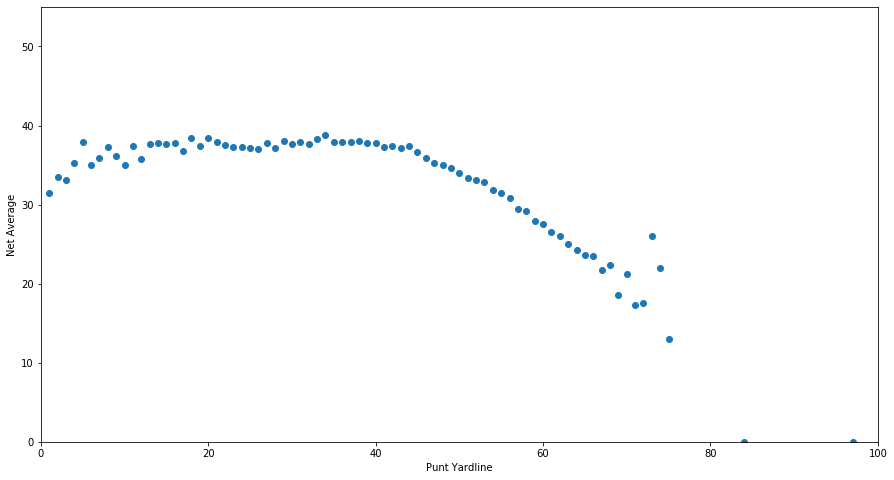

In [476]:
X_punt = punt_distance.groupby('Yardline').apply(lambda y: y['Yardline']).drop_duplicates().to_numpy()[:, np.newaxis]
y_punt = punt_distance.groupby('Yardline').apply(lambda y: y['Net'].mean()).to_numpy()
fig, ax = plt.subplots(1, 1,figsize=(15,8))
ax.scatter(X_punt, y_punt);
ax.set_ylim((0, 55))
ax.set_xlim((0, 100))
ax.set_ylabel("Net Average");
ax.set_xlabel("Punt Yardline");

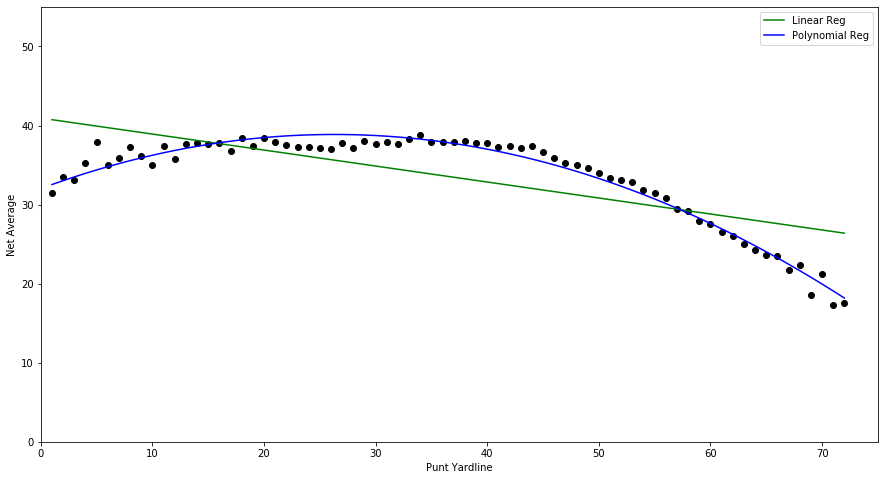

In [477]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import Pipeline


base_set = punt_distance[punt_distance.Yardline <= 72.5]
X = base_set.groupby('Yardline').apply(lambda y: y.Yardline).drop_duplicates().to_numpy()[:, np.newaxis]
y = base_set.groupby('Yardline').apply(lambda y: y['Net'].mean()).to_numpy()

# print(X)

lin = LinearRegression()  
lin.fit(X, y) 

poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X)
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

# lin2 = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])
# lin2.fit(X_poly, y)

fig, ax = plt.subplots(1, 1,figsize=(15,8))
# Visualising the Linear Regression results 
ax.scatter(X, y, color = 'black') 
ax.set_ylim((0, 55))
ax.set_xlim((0, 75))
ax.set_ylabel("Net Average");
ax.set_xlabel("Punt Yardline");
ax.plot(X, lin.predict(X), color = 'g', label="Linear Reg") 
ax.plot(X, lin2.predict(poly.fit_transform(X)), color = 'b', label="Polynomial Reg") 
ax.legend();

In [478]:
lin2.coef_

array([ 0.        ,  0.52053388, -0.0098997 ])

In [479]:
exp_punt_net = pd.DataFrame(data={"Yardline":range(1, 101)})
exp_punt_net['ExpPuntNet'] = lin2.predict(poly.fit_transform(exp_punt_net.Yardline.to_numpy()[:, np.newaxis]))
exp_punt_net.to_csv('results/punt_sr.csv', index=False, sep=",") # only uncomment to save the file
exp_punt_net

,Yardline,ExpPuntNet
0,1,32.537211
1,2,33.028045
2,3,33.499081
3,4,33.950317
4,5,34.381753
5,6,34.793391
6,7,35.185228
7,8,35.557267
8,9,35.909506
9,10,36.241945


In [480]:
# lin2.coef_[2] + (lin2.coef_[1] * (25 ** 1)) + (lin2.coef_[0] * (25 ** 2))
# 3 - 2 * x + x ** 2 - x ** 3
# [ 3., -2.,  1., -1.]

In [ ]:
punts = punt_distance.copy()
succ_punt_curve = pd.read_csv("results/punt_sr.csv", encoding="latin-1")
def is_punt_successful(ydline, net):
    return net >= succ_punt_curve[succ_punt_curve.Yardline == ydline].ExpPuntNet.to_list()[0]

def calc_punt_sharpnet(ydline, net):
    return (net / succ_punt_curve[succ_punt_curve.Yardline == ydline].ExpPuntNet.to_list()[0]) * 100

def calculate_clock(mins, secs, period):
    time = (mins * 60) + secs + (900 * (period - 3))
    return time

def calc_punt_surrender_index(row):
    fp = 0
    if (row.Yardline <= 40):
        fp = 1.0
    elif (40 < row.Yardline <= 50):
        fp = 1.1 ** (row.Yardline - 40)
    else:
        fp = 2.59 * 1.2 ** (row.Yardline - 50)
        
    first_down = 0
    if (row.YdsToGo <= 1):
        first_down = 1.0
    elif (2 <= row.YdsToGo <= 3):
        first_down = 0.8
    elif (4 <= row.YdsToGo <= 6):
        first_down = 0.6
    elif (7 <= row.YdsToGo <= 9):
        first_down = 0.4
    else:
        first_down = 0.2
        
    score = 0
    if (row.ScoreMargin > 0):
        score = 1
    elif (row.ScoreMargin == 0):
        score = 2
    elif (-8 <= row.ScoreMargin < 0):
        score = 4
    else:
        score = 3
        
    tm_f = 0    
    if (row.Period > 2) and (row.ScoreMargin <= 0):
        tm = row.ClockMinutes * 60 + row.ClockSeconds + 900 * (row.Period - 3)
        tm_f = ((tm * 0.001) ** 3) + 1
    else:
        tm_f = 1
    
    return fp * first_down * score * tm_f


punts['Successful'] = punts.apply(lambda x: is_punt_successful(x.Yardline, x.Net), axis=1)
punts["SHARPNet"] = punts.apply(lambda x: calc_punt_sharpnet(x.Yardline, x.Net), axis=1)
punts["SurrenderIndex"] = punts.apply(lambda x: calc_punt_surrender_index(x), axis=1)
# punts.sort_values(by="SurrenderIndex", ascending=False, inplace=True)
punts['SIRank'] = 1 - punts.SurrenderIndex.rank(pct = True, ascending=False)
# print(punts.Successful.value_counts(normalize=True))
punts.head(10)

In [ ]:
# punts.sort_values(by="SIRank",ascending=False).head(10)
punts[punts.index == 25798] #.PlayText.to_list()

In [ ]:
# Finding bad punt indices where the yardline has been mislabeled
punt_plays.loc[(punt_plays.away == punt_plays.offense) & (punt_plays.yard_line >= 72.5) & (punt_plays.index.isin(punts[(punts.SIRank >= 0.99)].Index.to_list()))][['yard_line','play_text']].index.to_list()

In [ ]:
punts[(punts.Offense == "Georgia Tech") & (punts.Season == 2019)].sort_values(by="SIRank", ascending=False).head(10)

In [ ]:
# Punt SR by team, YoY
team_punts = punts.copy().groupby(['Season', 'Offense'])
# print(team_punts.groups)
ratings = team_punts.apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Successful == True]) / len(x)))
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Season",'Offense','PuntSR']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='PuntSR', index='Offense', columns='Season').reset_index()
# pivot.reset_index(inplace=True)
pivot
# pivot.corr()

In [ ]:
# GT Punt SR
pivot[pivot.Offense == 'Georgia Tech']

In [ ]:
## FG Exp Value

fg_plays = pbp_data[pbp_data.play_type.str.contains("Field Goal")]
fg_set = pd.DataFrame(columns=["Index","Offense","Season","PlayText","Yardline","Distance","Status"])
fg_set["Index"] = fg_plays.index
fg_set["Season"] = fg_set.apply(lambda x: fg_plays.year[x.Index],axis=1)
fg_set["Offense"] = fg_set.apply(lambda x: fg_plays.offense[x.Index],axis=1)
fg_set["PlayText"] = fg_set.apply(lambda x: fg_plays.play_text[x.Index],axis=1)
fg_set["Yardline"] = fg_set.apply(lambda x: 0 if (x.Index == None) else fg_plays.yard_line[x.Index],axis=1)
fg_set["Distance"] = (50 - (fg_set.Yardline % 50)) + 17

def verify_fg_status(play_type):
    if ("Good" in play_type):
        return "Good"
    elif ("Blocked" in play_type):
        return "Blocked"
    elif ("Missed" in play_type):
        return "Missed"
    else:
        return "Unknown"

fg_set["Status"] = fg_set.apply(lambda x: verify_fg_status(fg_plays.play_type[x.Index].replace("Field Goal ","")),axis=1)
fg_set.head(15)

In [ ]:
X_fg = fg_set.groupby('Distance').apply(lambda y: y.Distance).drop_duplicates()[:,np.newaxis]
y_fg = fg_set.groupby('Distance').apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Status == 'Good']) / len(x)))[:,np.newaxis]
fig, ax = plt.subplots(1, 1,figsize=(15,8))
ax.scatter(X_fg, y_fg);
# ax.set_ylim((0, 55))
ax.set_xlim((min(X_fg)-2, 65)) # modern record is 65 yards from KState in 98
ax.set_ylabel("% Made");
ax.set_xlabel("FG Distance");

In [ ]:
lin_fg = LinearRegression()  
lin_fg.fit(X_fg, y_fg) 

poly_fg = PolynomialFeatures(degree = 2) 
X_poly_fg = poly.fit_transform(X_fg)
poly_fg.fit(X_poly_fg, y_fg) 
lin2_fg = LinearRegression() 
lin2_fg.fit(X_poly_fg, y_fg) 

fig, ax = plt.subplots(1, 1,figsize=(15,8))
# Visualising the Linear Regression results 
ax.scatter(X_fg, y_fg, color = 'black') 
# ax.set_ylim((0, 55))
# ax.set_xlim((0, 75))
ax.set_ylabel("% Made");
ax.set_xlabel("FG Distance");
ax.plot(X_fg, lin_fg.predict(X_fg), color = 'g', label="Linear Reg") 
# ax.plot(X_fg, lin2_fg.predict(X_poly_fg), color = 'b', label="Polynomial Reg") 
ax.legend();

In [ ]:
exp_fg_value = pd.DataFrame(columns=["Distance","Accuracy"])
exp_fg_value.Distance = fg_set.groupby('Distance').apply(lambda y: y.Distance).drop_duplicates()
exp_fg_value.Accuracy = lin_fg.predict(exp_fg_value.Distance[:,np.newaxis])#fg_set.groupby('Distance').apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Status == 'Good']) / len(x))).to_numpy()
exp_fg_value['ExpFGValue'] = exp_fg_value.apply(lambda x: x.Accuracy * 3.0, axis=1)
exp_fg_value.reset_index(drop=True, inplace=True)
exp_fg_value.set_index(keys=['Distance'])
exp_fg_value.to_csv('results/fg_sr.csv', index=False, sep=",") # only uncomment to save the file
exp_fg_value

In [ ]:
# FG SR by team, YoY
fgs = fg_set.copy()
exp_fg = pd.read_csv("results/fg_sr.csv", encoding="latin-1")
def assign_fg_exp_val(distance):
    return exp_fg[exp_fg.Distance == distance].ExpFGValue.to_list()[0]
def generate_actual_val(x):
    if (x.Status == 'Good'):
        return 3
    else:
        return 0

fgs['ExpFGValue'] = fgs.apply(lambda x: assign_fg_exp_val(x.Distance), axis=1)
fgs['NetFGValue'] = fgs.apply(lambda x: generate_actual_val(x) - x.ExpFGValue, axis=1)

team_fg = fgs.copy().groupby(['Season', 'Offense'])
# print(team_punts.groups)
ratings_fg = team_fg.apply(lambda x: x.NetFGValue.mean())
team_fr_szn_fg = ratings_fg.reset_index()
team_fr_szn_fg.columns = ["Season",'Offense','FGSR']
team_fr_szn_fg

pivot_fg = team_fr_szn_fg.pivot_table(values='FGSR', index='Offense', columns='Season').reset_index()
# pivot.reset_index(inplace=True)
pivot_fg
# pivot.corr()

In [ ]:
pivot_fg[pivot_fg.Offense == 'Georgia Tech']

In [ ]:
# 2019 Net FG Value per Kick rankings 
pivot_fg.dropna()[['Offense',2019]].sort_values(by=2019,ascending=False)

In [ ]:
# ST SP+ (circa 2016): 44% place-kicking, 24% punting, 14% kickoffs, 14% kick returns, 3% punt returns.